# Support Vector Machine and Neural Network Classifiers

This project explores classification tasks using Support Vector Machines (SVM) and Neural Networks (NN). 
We aim to understand how SVMs find hyperplanes for linear and non-linear separable data using different kernels 
and optimize hyperparameters for better model performance.

---

## Objectives:
1. Perform classification on dataset_1 using SVM with a linear kernel.
2. Experiment with the C-parameter to identify hard and soft margins.
3. Explore datasets 2 and 3 using SVMs with various kernels and evaluate out-of-sample performance.
4. Investigate Neural Network classifiers, optimizing hyperparameters with Bayesian optimization.

## Tools and Libraries:
- Python libraries: NumPy, Matplotlib, scikit-learn, and scikit-optimize.
- Visualization for SVM margins and decision boundaries.


- Author: **Kaushal Bhavsar**
- LinkedIn : https://www.linkedin.com/in/kb07/
- Github: Mister-kaushalam
- Email - Kaushalbhavsar0007@gmail.com

# Imports

In [ ]:
!pip install numpy matplotlib scikit-learn scikit-optimize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [2]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [14]:
np.int = int  #need to change this because of this error -> """AttributeError: module 'numpy' has no attribute 'int'. `np.int` was a deprecated alias for the builtin `int`."""

Some functions that we'll use later

In [3]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [4]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_errors = 1- train_scores
    test_errors = 1-test_scores
    
    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")

    
    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [6]:
class MLPWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10, layer3=10, layer4 =10, activation='relu', alpha=0.0001, max_iter=1000):
        self.layer1 = layer1
        self.layer2 = layer2 #added new layer
        self.layer3 = layer3 #added new layer
        self.layer4 = layer4 #added new layer
        self.activation = activation #testing different activation functions
        self.alpha = alpha #Regularization parameter
        self.max_iter = max_iter

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2, self.layer3,  self.layer4],
            activation=self.activation,
            alpha=self.alpha,
            max_iter=self.max_iter
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [7]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear','rbf', 'sigmoid', 'poly']),
    },
    n_iter=30,
    cv = 10, #cross-validation added
)

In [8]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100),
    },
    n_iter=30,
)

## SVM Classification on Linearly Separable Data

Focuses on:
- SVM classification with a linear kernel.
- Experimenting with the C-parameter for margin adjustments.

Loading the Dataset

In [24]:
data = np.loadtxt(r'C:\Users\kaush\OneDrive\Documents\UL Code\e-tivity3\dataset_1_train.csv', delimiter=',')
X= data[: , :-1] #all columns except last one
y = data[:, -1] #last column

Let's start with a simple SVM and fit it on the training data

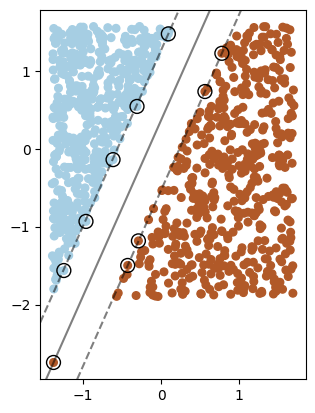

In [25]:
classifier = SVC(kernel="linear") #Support Vector Classifer class initialization with a Linear kernal
classifier.fit(X, y) #fitting the model
plot_margin(X, y, classifier)

C:\Users\kaush\AppData\Local\Temp\ipykernel_8552\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


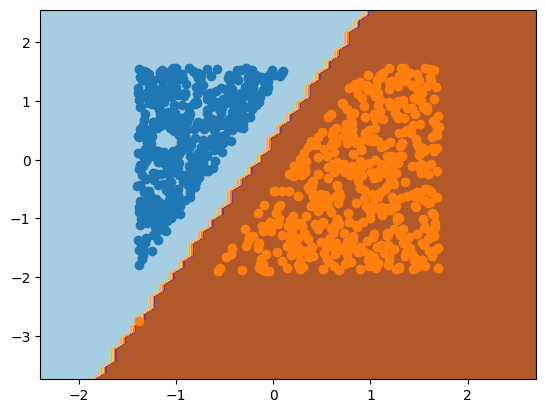

In [26]:
plot_decisions(X, y , classifier)

The SVM performs pretty well. It's expected as the dataset is linearly sperable with decent "gap" between the classes i.e. the SVM is easily able to fit a hypothesis on the data. Let's try to find out a better model by Regularizing the model.

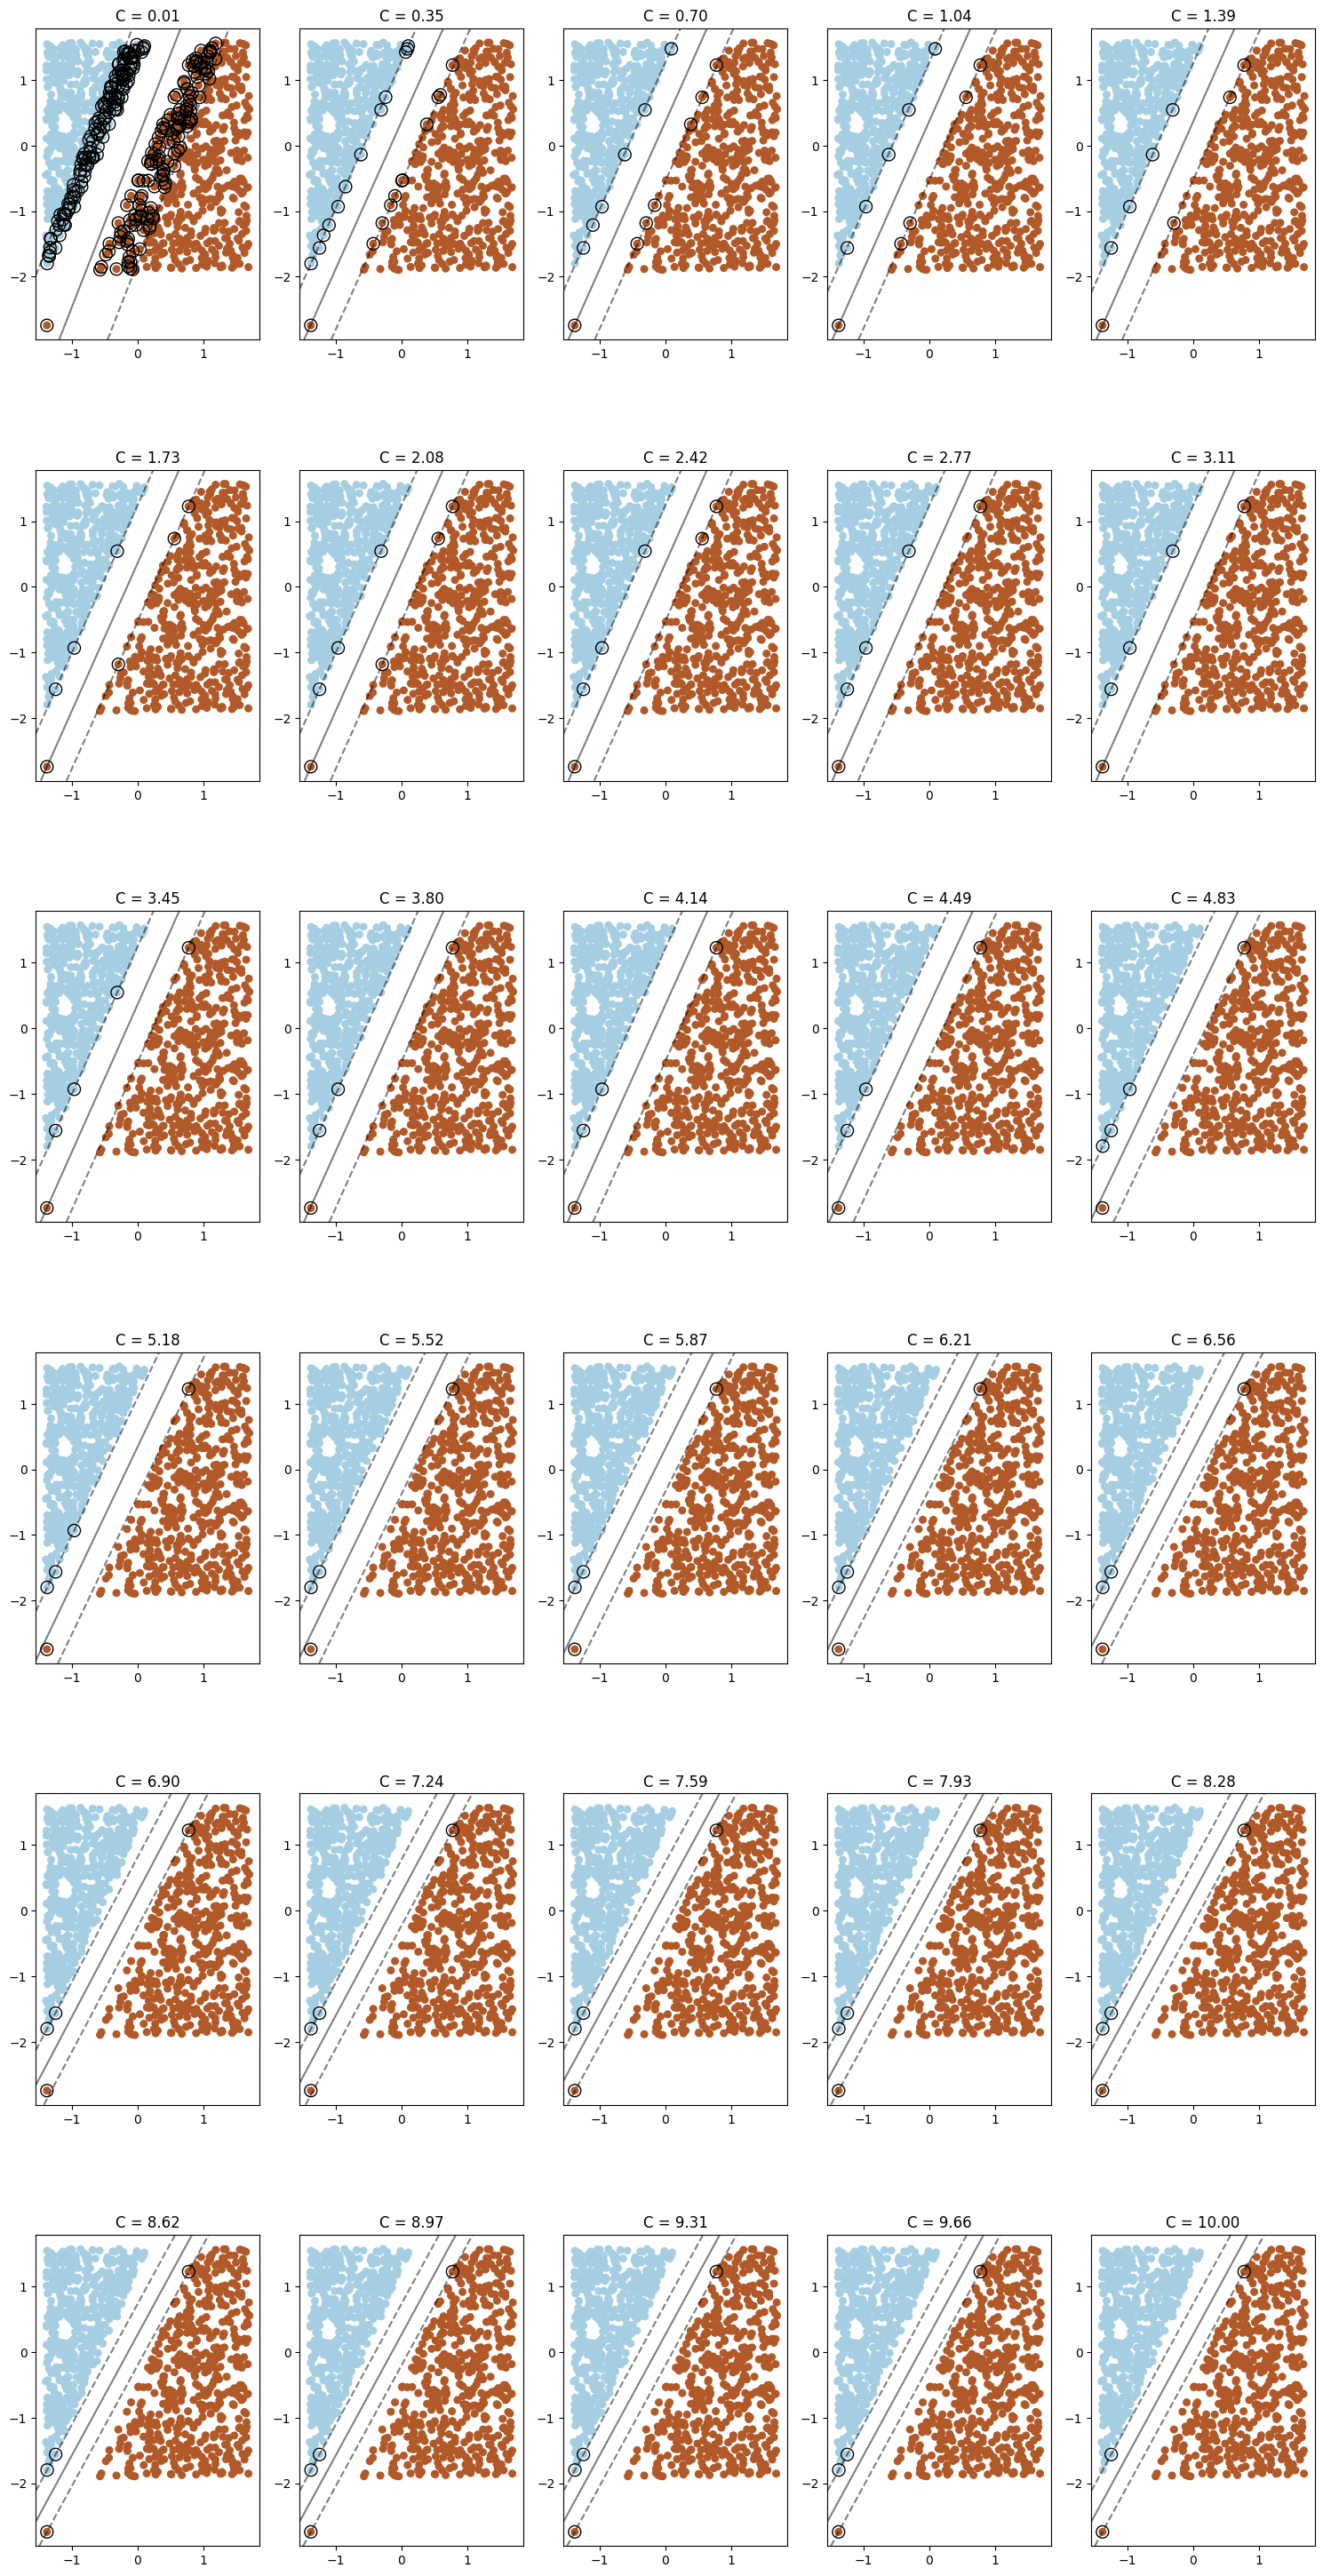

In [13]:
fig, axes = plt.subplots(6, 5, figsize=(15, 30))
choiceC = np.linspace(0.01, 10, 30) #choise of the regularizer paramenter - "C"

for ax, C in zip(axes.flatten(), choiceC):
    clf = SVC(C=C, kernel="linear")
    clf.fit(X, y)
    
    plt.sca(ax)  # Set the current axes
    plot_margin(X, y, clf)
    ax.set_title(f"C = {C:.2f}")

plt.tight_layout()
plt.show()

After C = 5, there's not much difference in the margins, so I'll plot the graphs again and check more granular C values between 0 and 5

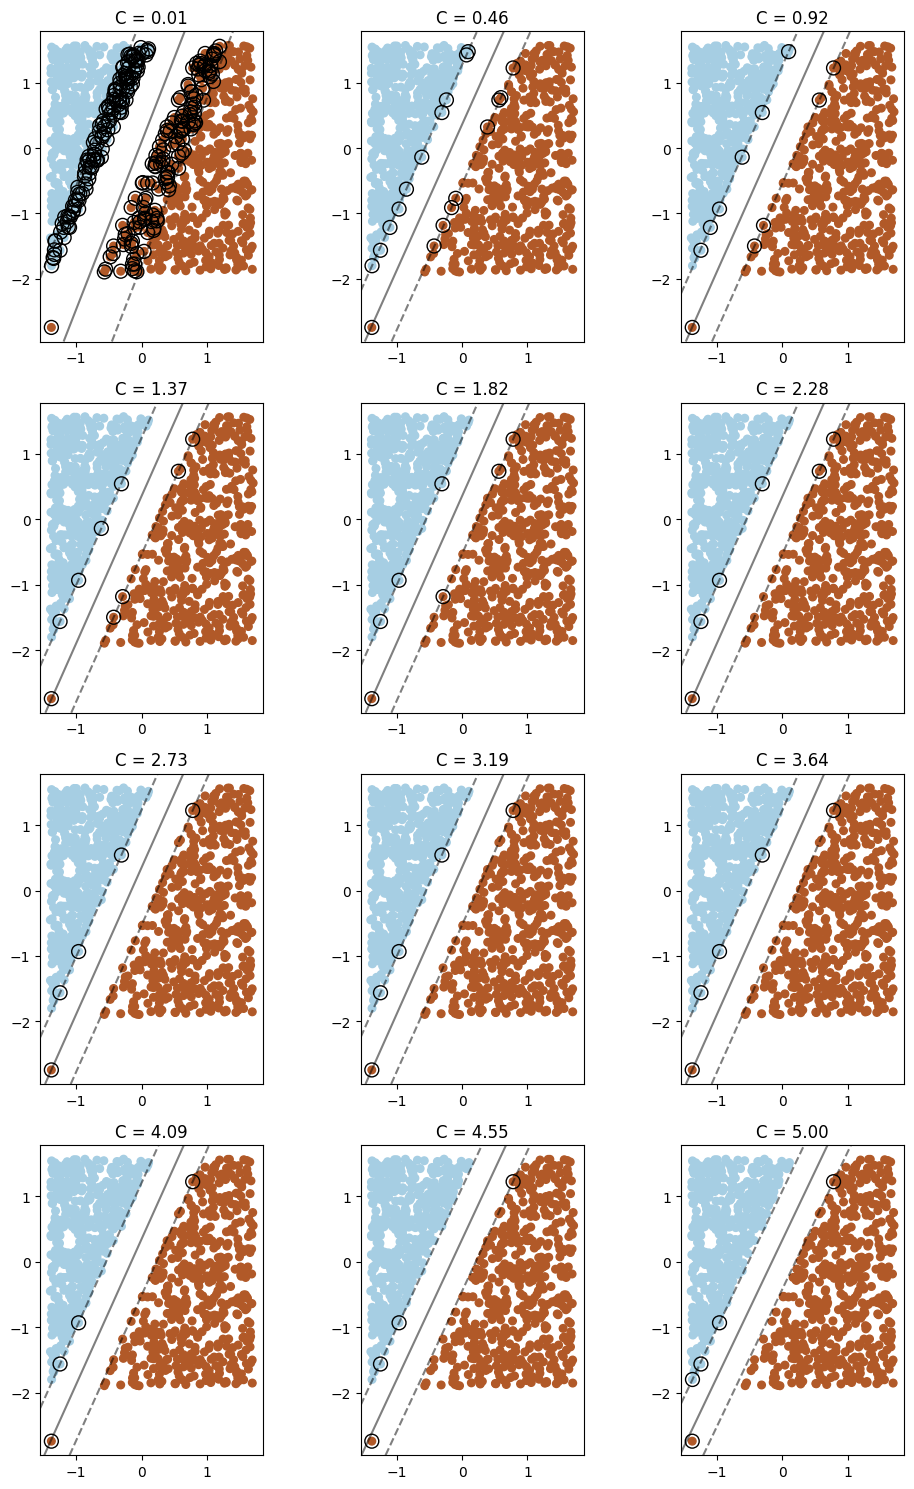

In [27]:
fig, axes = plt.subplots(4, 3, figsize=(10, 15))
choiceC = np.linspace(0.01, 5, 12)

for ax, C in zip(axes.flatten(), choiceC):
    clf = SVC(C=C, kernel="linear")
    clf.fit(X, y)
    
    plt.sca(ax)  # Set the current axes
    plot_margin(X, y, clf)
    ax.set_title(f"C = {C:.2f}")

plt.tight_layout()
plt.show()

As we can see, at C=0.46 we have a good margin with sufficient support vectors (total 19 support vectors). The margin is wide enough to not overfit the data and still classifying with decent decision boundry. I'll use this one

<bound method ClassifierMixin.score of SVC(C=0.46, kernel='linear')>


Text(0.5, 1.0, 'SVM without Regularizer')

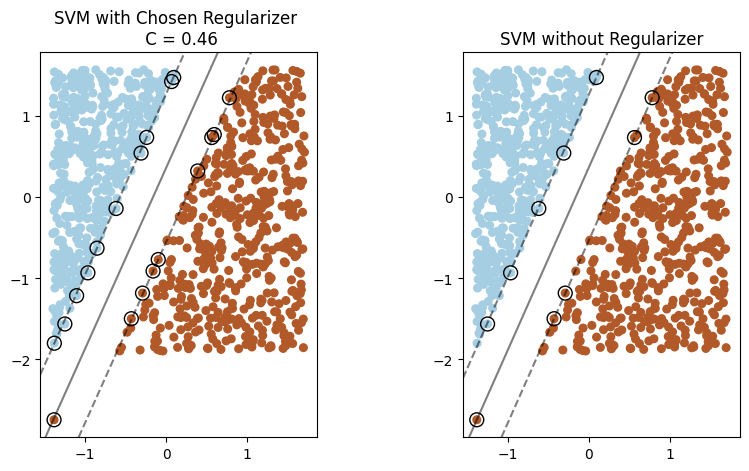

In [30]:
plt.figure(figsize=(10, 5))

classifer_chosen = SVC(C=0.46, kernel="linear")
classifer_chosen.fit(X,y)
print(classifer_chosen.score)
plt.subplot(1, 2, 1)
plot_margin(X, y, classifer_chosen)
plt.title("SVM with Chosen Regularizer \n C = 0.46")

plt.subplot(1, 2, 2)
plot_margin(X, y, classifier)
plt.title("SVM without Regularizer")

#### Some info about the Support Vectors of the Choosen SVM Classifer

In [36]:
print("Support Vectors for class -1 with C 0.46 ------>" , classifer_chosen.n_support_[0])
print("Support Vectors for class 1 with C 0.46 ------>" , classifer_chosen.n_support_[1])

print("Total Support vectors = " , sum(classifer_chosen.n_support_))

Support Vectors for class -1 with C 0.46 ------> 10
Support Vectors for class 1 with C 0.46 ------> 9
Total Support vectors =  19


There's a better balance between overfitting and generalization. The wider margin and tolerance for misclassifications can help prevent overfitting, potentially leading to a model that generalizes better to unseen data.

Text(0.5, 1.0, 'SVM with Hard Regularizer C = 10')

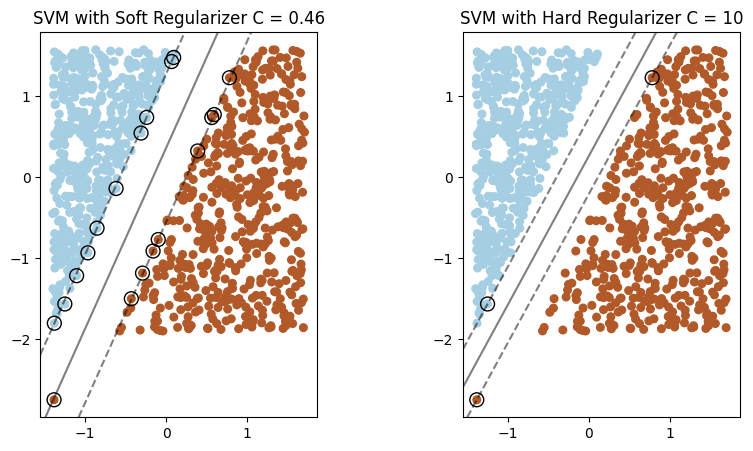

In [17]:
plt.figure(figsize=(10, 5))

classifer_chosen = SVC(C=0.46, kernel="linear")
classifer_chosen.fit(X,y)
plt.subplot(1, 2, 1)
plot_margin(X, y, classifer_chosen)
plt.title("SVM with Soft Regularizer C = 0.46")

plt.subplot(1, 2, 2)
classifer_hard = SVC(C=10, kernel="linear")
classifer_hard.fit(X,y)
plot_margin(X, y, classifer_hard)
plt.title("SVM with Hard Regularizer C = 10")

## Reflection

### Soft margin:

From the last plot we can see the difference between the SVM model which has a soft margin and a hard margin. On the left, we have the soft marging. Notice how the model with the soft margin ingores the noise from class 1, on the botton left at coordinate approximately ~(-1.8, -2.8). While the hard regularizer considered that noice as a support vector and created a much narrower margin. This hard regularized model will not generalize and may lead to overfitting.

The model with the soft marging should have significantly higher number of support vectors generally, which is shown in the last figure above.

### Regularization Tuning

The Regularization parameter "C" was effectively tuned by trail and error. I initially started by tatking a wider range of number as value for "C", to understand the general trend of model's performance with increasing in the Regulaizer's strength. I noticed that after 5, there were no significant changes in the model, so I limit the range from 0 to 5 and run experiments with 12 different values in that range. (I choose 12 so I can fit the graphs perfectly in a 4x3 plot's grid.)

We can see that with C=0.01, there are many points that are inside the margin. The margin is the widest of all but it's underfitting the data severly. As the range grew to C = 10, we can see that the margin is extremely narrow with only 2 support vectors, one from each class. This is classic overfitting where the noise in the data has caused the model to overfit the data. A sweet spot with most number of support vectors were found at C = 0.46.



# Kernel Exploration and Hyperparameter Optimization

Focuses on:
- Using different SVM kernels for datasets 2 and 3.
- Hyperparameter tuning for SVM models, emphasizing out-of-sample performance.

### Dataset 2

In [45]:
#load the dataset 2
TrainDataset2 = np.loadtxt('dataset_2_train.csv', delimiter=",")
TestDataset2 = np.loadtxt('dataset_2_test.csv', delimiter=",")

X_train_Dataset2 = TrainDataset2[:, :-1]
y_train_Dataset2 = TrainDataset2[:,-1]

X_test_Dataset2 = TestDataset2[:,:-1]
y_testDataset2 = TestDataset2[:,-1]

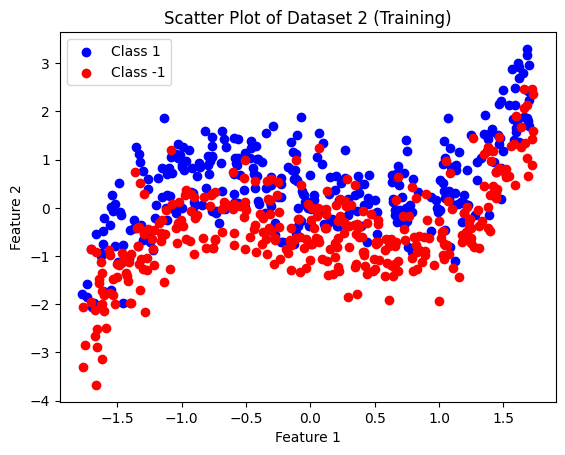

In [46]:
# Separate data points based on their class labels
class_0 = X_train_Dataset2[y_train_Dataset2 == 0]
class_1 = X_train_Dataset2[y_train_Dataset2 == 1]

# Plot the data points
plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 1')
plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class -1')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Dataset 2 (Training)')
plt.legend()
plt.show()

The linear kernel we were using till now will not work here as the data is not linearly separable. We need to find the most optimal kernal for this dataset. We'll use the Bayesian Optimizer to search thorought the hyper parameters and find the optimal hyper parameters.

##### Hyperparameter selections

To optimize the mode's performance, I have selected paramters as

'C': Real(1e-3, 1e+3, prior='log-uniform')

and 4 different kernals - Linear, RBF, Signmoid and Poly. I have also used 10-fold cross-validation.

In [47]:
optSVM1_lin.fit(X_train_Dataset2, y_train_Dataset2)

BayesSearchCV(cv=10, estimator=SVC(), n_iter=30,
              search_spaces={'C': Real(low=0.001, high=1000.0, prior='log-uniform', transform='normalize'),
                             'kernel': Categorical(categories=('linear', 'rbf', 'sigmoid', 'poly'), prior=None)})

Evidence of a structured approach to the selection of hyper-parameters

In [48]:
score = optSVM1_lin.score(X_test_Dataset2, y_testDataset2)
print("Score = " ,score)

print("-----PROPOSED BEST PARAMETERS--------")
print(optSVM1_lin.best_params_)

Score =  0.7552870090634441
-----PROPOSED BEST PARAMETERS--------
OrderedDict({'C': 18.525604240782403, 'kernel': 'rbf'})


let's plot the decision boundry using the optimized hyper-parameters

C:\Users\kaush\AppData\Local\Temp\ipykernel_17084\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
C:\Users\kaush\AppData\Local\Temp\ipykernel_17084\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


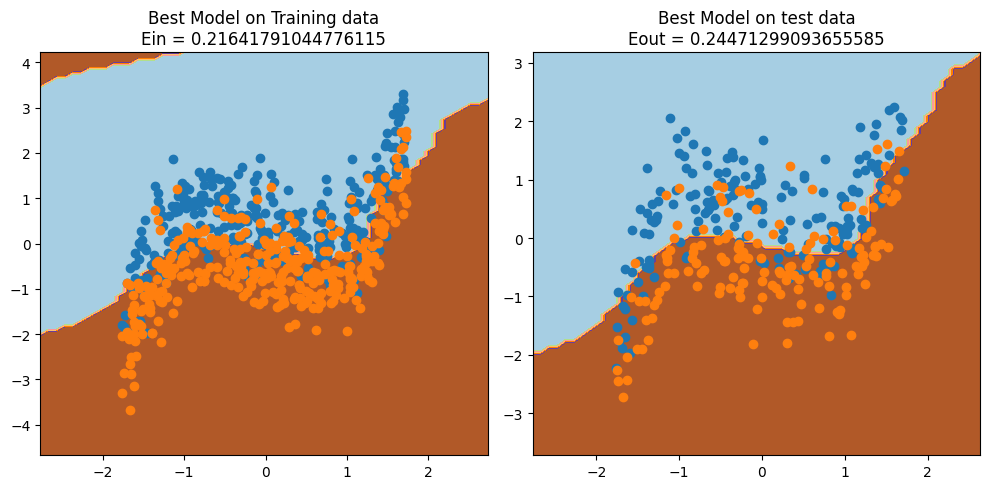

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
Ein = 1 - optSVM1_lin.score(X_train_Dataset2, y_train_Dataset2)
plot_decisions(X_train_Dataset2, y_train_Dataset2, optSVM1_lin)
plt.title(f"Best Model on Training data\nEin = {Ein}")

plt.subplot(1, 2, 2)
Eout = 1 - optSVM1_lin.score(X_test_Dataset2, y_testDataset2)
plot_decisions(X_test_Dataset2, y_testDataset2, optSVM1_lin)
plt.title(f"Best Model on test data\nEout = {Eout}")

plt.tight_layout()
plt.show()

### Dataset 3

In [9]:
#load the dataset 2
TrainDataset3 = np.loadtxt('dataset_3_train.csv', delimiter=",")
TestDataset3 = np.loadtxt('dataset_3_test.csv', delimiter=",")

X_train_Dataset3 = TrainDataset3[:, :-1]
y_train_Dataset3 = TrainDataset3[:,-1]

X_test_Dataset3 = TestDataset3[:,:-1]
y_testDataset3 = TestDataset3[:,-1]

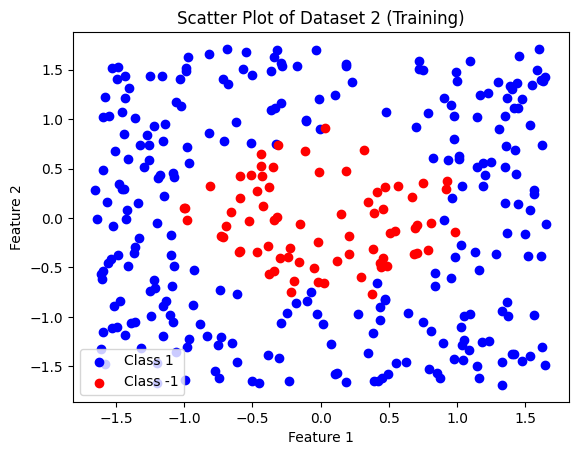

In [10]:
# Separate data points based on their class labels
class_0 = X_train_Dataset3[y_train_Dataset3 == 0]
class_1 = X_train_Dataset3[y_train_Dataset3 == 1]

# Plot the data points
plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 1')
plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class -1')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Dataset 2 (Training)')
plt.legend()
plt.show()

Again, this dataset is also not linearly separable. Looks like linear kernel will also not work here so we'll try different sets of kernel to check which one works the best. We'll set up the BayesOptimizer same as dataset 2's optimizer. 

Evidence of a structured approach to the selection of hyper-parameters

In [25]:
optSVM1_lin.fit(X_train_Dataset3, y_train_Dataset3)

score = optSVM1_lin.score(X_test_Dataset3, y_testDataset3)
print("Score = " ,score)

print("-----BEST PARAMETERS--------")
print(optSVM1_lin.best_params_)

Score =  0.9636363636363636
-----BEST PARAMETERS--------
OrderedDict({'C': 126.17328075897052, 'kernel': 'rbf'})


C:\Users\kaush\AppData\Local\Temp\ipykernel_17084\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
C:\Users\kaush\AppData\Local\Temp\ipykernel_17084\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


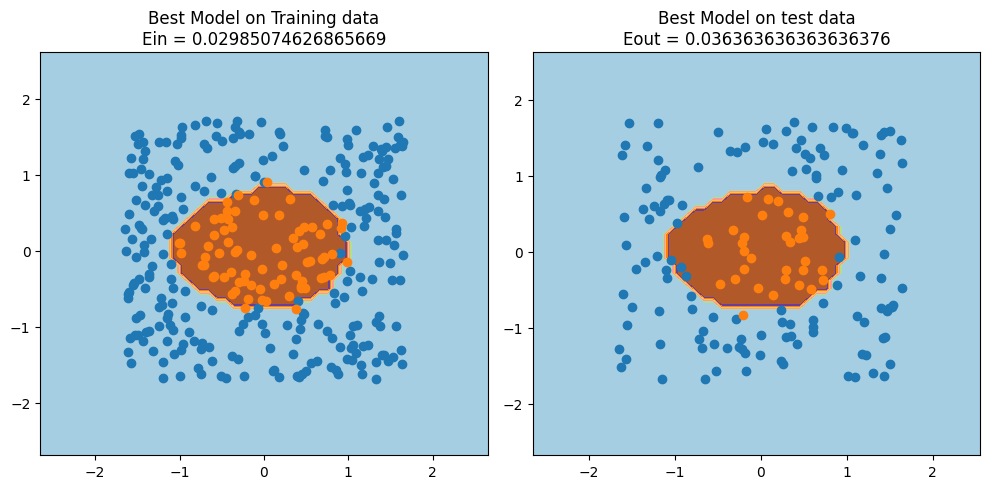

In [26]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
Ein = 1 - optSVM1_lin.score(X_train_Dataset3, y_train_Dataset3)
plot_decisions(X_train_Dataset3, y_train_Dataset3, optSVM1_lin)
plt.title(f"Best Model on Training data\nEin = {Ein}")

plt.subplot(1, 2, 2)
Eout = 1 - optSVM1_lin.score(X_test_Dataset3, y_testDataset3)
plot_decisions(X_test_Dataset3, y_testDataset3, optSVM1_lin)
plt.title(f"Best Model on test data\nEout = {Eout}")

plt.tight_layout()
plt.show()

# Neural Networks: Hyperparameter Optimization and Bayesian Techniques

Focuses on:
- Exploring Neural Network models for datasets 2 and 3.
- Using Bayesian optimization for efficient hyperparameter search.

#### Dataset 2

In [27]:
# Define the search space for hyperparameters
optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 50),
        'layer2': Integer(1, 50),
        'layer3': Integer(1,50),
        'layer4': Integer(1,50),
        'activation': ['relu', 'logistic', 'tanh', 'identity'],  # Different activation functions
        'alpha': (1e-5, 1e-1, 'log-uniform'),  # Regularization strength
        'max_iter': Integer(30, 50),  # Maximum number of iterations
    },
    n_iter=30,
    cv=5,  # Number of cross-validation folds
    verbose=0,
)

Here I have used 4 Layers, 4 different activation functions and L2 Regulaizer. I have set 5-Fold Cross validation.

Evidence of a structured approach to the selection of hyper-parameters

In [ ]:
optNN1.fit(X_train_Dataset2, y_train_Dataset2)

In [29]:
score = optNN1.score(X_test_Dataset2, y_testDataset2)
print("Score = " ,score)

print("-----BEST PARAMETERS--------")
print(optNN1.best_params_)

Score =  0.743202416918429
-----BEST PARAMETERS--------
OrderedDict({'activation': 'tanh', 'alpha': 1.551539242839616e-05, 'layer1': 50, 'layer2': 50, 'layer3': 50, 'layer4': 25, 'max_iter': 45})


In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
Ein = 1 - optNN1.score(X_train_Dataset2, y_train_Dataset2)
plot_decisions(X_train_Dataset2, y_train_Dataset2, optNN1)
plt.title(f"Best Model on Training data\nEin = {Ein}")

plt.subplot(1, 2, 2)
Eout = 1 - optNN1.score(X_test_Dataset2, y_testDataset2)
plot_decisions(X_test_Dataset2, y_testDataset2, optNN1)
plt.title(f"Best Model on test data\nEout = {Eout}")

plt.tight_layout()
plt.show()

## Dataset 3 - Neural Network

In [18]:
#Tried with 3 and 4 Layer Neural Network, but 4 layered gave best results so used that.
class MLPWrapperV3(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10, layer3=10, layer4=10, activation='relu', alpha=0.0001, max_iter=1000):
        self.layer1 = layer1
        self.layer2 = layer2
        self.layer3 = layer3
        self.layer4 = layer4
        self.activation = activation
        self.alpha = alpha
        self.max_iter = max_iter

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2, self.layer3, self.layer4],
            activation=self.activation,
            alpha=self.alpha,
            max_iter=self.max_iter
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

I tried with 3 layers, but 4 layers were working much better.

In [19]:
# Define the search space for hyperparameters
optNN3 = BayesSearchCV(
    estimator=MLPWrapperV3(),
    search_spaces={
        'layer1': Integer(1, 50),
        'layer2': Integer(1, 50),
        'layer3': Integer(1,50),
        'layer4': Integer(1,50),
        'activation': ['relu', 'logistic', 'tanh', 'identity'],  # Different activation functions
        'alpha': (1e-5, 1e-1, 'log-uniform'),  # Regularization strength
        'max_iter': Integer(30, 50),  # Maximum number of iterations
    },
    n_iter=30,
    cv=5,  # Number of cross-validation folds
    verbose=0,
)

Evidence of a structured approach to the selection of hyper-parameters

In [ ]:
optNN3.fit(X_train_Dataset3, y_train_Dataset3)

In [21]:
score = optNN3.score(X_test_Dataset3, y_testDataset3)
print("Score = " ,score)

print("-----BEST PARAMETERS--------")
print(optNN3.best_params_)

Score =  0.9696969696969697
-----BEST PARAMETERS--------
OrderedDict({'activation': 'relu', 'alpha': 0.004430043383887725, 'layer1': 28, 'layer2': 39, 'layer3': 43, 'layer4': 50, 'max_iter': 50})


C:\Users\kaush\AppData\Local\Temp\ipykernel_8552\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
C:\Users\kaush\AppData\Local\Temp\ipykernel_8552\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


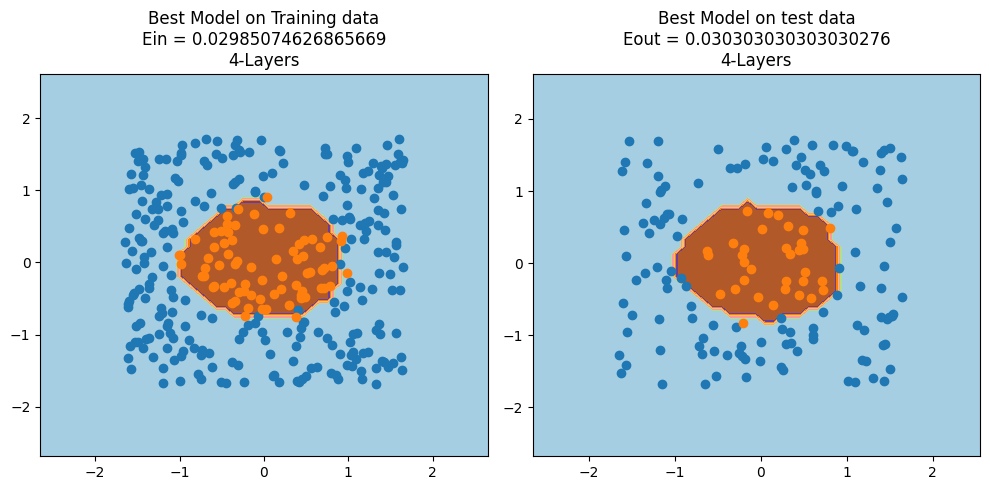

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
Ein = 1 - optNN3.score(X_train_Dataset3, y_train_Dataset3)
plot_decisions(X_train_Dataset3, y_train_Dataset3, optNN3)
plt.title(f"Best Model on Training data\nEin = {Ein}\n4-Layers")

plt.subplot(1, 2, 2)
Eout = 1 - optNN3.score(X_test_Dataset3, y_testDataset3)
plot_decisions(X_test_Dataset3, y_testDataset3, optNN3)
plt.title(f"Best Model on test data\nEout = {Eout}\n4-Layers")

plt.tight_layout()
plt.show()

## Reflection


Initially, I though of using GridSearchCV for hyper parameter tuning as I was unaware of Bayesian Optimizer. This is something that I learning during this project. I understood that the key idea behind Bayesian optimization is to model the objective function (e.g., model performance metric such as accuracy or loss) as a probabilistic surrogate function. This surrogate function provides an estimate of the true objective function and its uncertainty at each point in the parameter space.

It's much more efficient than GridSearchCV.

I tested bunch of different hyper paramters for different models, and here's what I've found worked best for different datasets provided.

| Dataset | Model | Best Parameters Discovered | Ein  | Eout |
|---------|-------|----------------------------|------|------|
| 2       | SVM   | {'C': 1.0073674161229038, 'kernel': 'rbf'} | 0.22 | 0.25 |
| 3       | SVM   | {'C': 133.53245181022714, 'kernel': 'rbf'} | 0.029 | 0.03 |
| 2       | NN    | {'activation': 'relu', 'alpha': 1e-05, 'layer1': 50, 'layer2': 31, 'layer3': 44, 'layer4': 34, 'max_iter': 50} | 0.21 | 0.24 |
| 3       | NN    | {'activation': 'relu', 'alpha': 0.0006812950339860762, 'layer1': 41, 'layer2': 44, 'layer3': 42, 'layer4': 23, 'max_iter': 49} | 0.02 | 0.03 |


For Dataset 2, the best hyperparameters for SVM were a regularization parameter (C) of 1.007 and an RBF kernel, while for Dataset 3, (C) was found to be 133.532 with an RBF kernel. 

For neural networks on Dataset 2; performed best with a ReLU activation function, an L2 regularization strength alpha of $(1 \times 10^{-5}$), and four hidden layers with sizes 50, 31, 44, and 34, trained for 50 iterations. On the other hand, Dataset 3 achieved optimal results with a ReLU activation function,alpha of $(6.81 \times 10^{-4})$, and four hidden layers with sizes 41, 44, 42, and 23, trained for 49 iterations.

Interestingly, the in-sample error and the out-of-sample error for the models are were close to each other. This means the regulizer is working well and the models are able to generalize well. There's no overfitting.

In conclusion, we have trained SVM and Neural network models succesfully. We have also used Bayesian optimizer to find the best hyperparameters for both the models. The optimized hyperparamter's performance is refelected by looking at the in-sample and out-of-sample error.

# Improvement to the code

It was pointed out to me by Maciej Augustynek that my NN model's performace is not as good as his. He included the alpha parameter in his code and found that his model's performance also went down. So, he tried again without the regulaization parameter and the model's performance improved. Hence. he concluded, the regulaization parameter was actually degrading my model's performance and I can improve the in-sample and out-of-sample error by removing the regulaization parameter.

I wish to try his experiment and see if it can improve my out-of-sample error. Here's the implementation of my NN model on dataset 3 again but without the regularization parameter this time.

In [37]:
#Same model as above but without the alpha parameter
class MLPWrapper_withoutC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10, layer3=10, layer4=10, activation='relu', max_iter=1000):
        self.layer1 = layer1
        self.layer2 = layer2
        self.layer3 = layer3
        self.layer4 = layer4
        self.activation = activation
        self.max_iter = max_iter

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2, self.layer3, self.layer4],
            activation=self.activation,
            max_iter=self.max_iter
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [38]:
# Define the search space for hyperparameters
optNN4 = BayesSearchCV(
    estimator=MLPWrapperV3(),
    search_spaces={
        'layer1': Integer(1, 50),
        'layer2': Integer(1, 50),
        'layer3': Integer(1,50),
        'layer4': Integer(1,50),
        'activation': ['relu', 'logistic', 'tanh', 'identity'],  # Different activation functions
        'max_iter': Integer(30, 50),  # Maximum number of iterations
    },
    n_iter=30,
    cv=5,  # Number of cross-validation folds
    verbose=0,
)

In [ ]:
optNN4.fit(X_train_Dataset3, y_train_Dataset3)

In [42]:
score = optNN4.score(X_test_Dataset3, y_testDataset3)
print("Score = " ,score)

print("-----BEST PARAMETERS--------")
print(optNN4.best_params_)

Score =  0.9575757575757575
-----BEST PARAMETERS--------
OrderedDict({'activation': 'relu', 'layer1': 50, 'layer2': 21, 'layer3': 35, 'layer4': 36, 'max_iter': 47})


C:\Users\kaush\AppData\Local\Temp\ipykernel_17084\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
C:\Users\kaush\AppData\Local\Temp\ipykernel_17084\31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


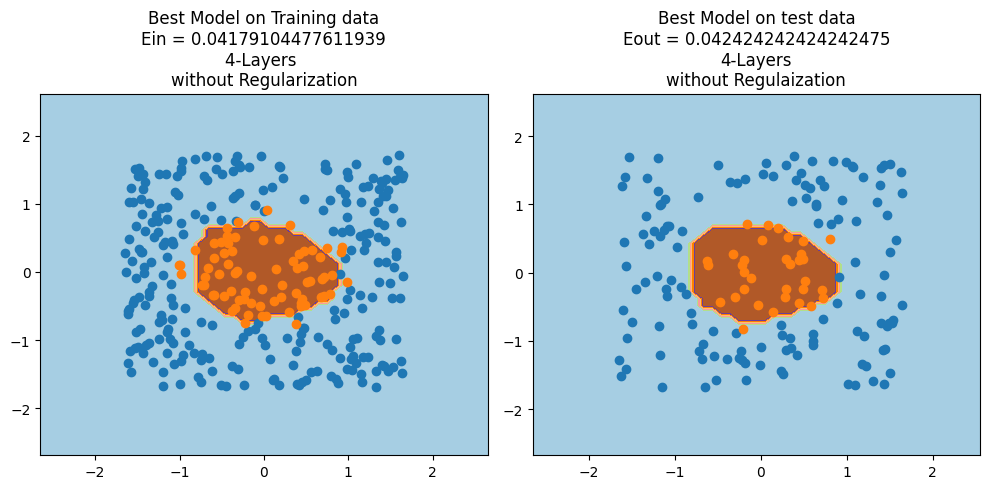

In [46]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
Ein = 1 - optNN4.score(X_train_Dataset3, y_train_Dataset3)
plot_decisions(X_train_Dataset3, y_train_Dataset3, optNN4)
plt.title(f"Best Model on Training data\nEin = {Ein}\n4-Layers \nwithout Regularization")

plt.subplot(1, 2, 2)
Eout = 1 - optNN4.score(X_test_Dataset3, y_testDataset3)
plot_decisions(X_test_Dataset3, y_testDataset3, optNN4)
plt.title(f"Best Model on test data\nEout = {Eout}\n4-Layers\nwithout Regulaization")
plt.tight_layout()
plt.show()

### Reflection after applying peer's feedback

The results are actaully different from what Maciej posted. The in-sample error increased from 0.02 to 0.04 and out-of-sample error increased from from 0.03 to 0.04. The performance actually reduced. So, I'll check again with Maciej, share my new results with him and I hope to discuss with him the new results. I'll also like to his experiment setup with mine.

The results I got makes sense to me. Regularization improves neural network generalization by penalizing complexity, encouraging the model to learn simple, universal patterns rather than memorizing the training data. This prevents overfitting, making the model more effective on unseen data. This doesn't mean that the model start to underfit. Since we followed a structured approach (baysean search on the parameters) to find out the best alpha (regulizer value), adding the regulizer with appropriate aplha value provide value to the Ein and Eout.


## Conclusion

This project demonstrates the application of SVM and NN classifiers on various datasets, highlighting the importance of:
- Kernel selection for non-linear separable data.
- Regularization with the C-parameter for SVMs to balance margin width and classification accuracy.
- Hyperparameter tuning for Neural Networks to improve model performance.

Further improvements can include applying these techniques to real-world datasets and experimenting with advanced optimization strategies.
